# Leios simulation analysis at tag `leios-2025w27`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: simple variant with conflicts

In [2]:
label <- "Rust simulator, mini-mainnet, full-with-tx-references, sharded, 1000 tx/s, 2 IB/s, 8 slot/stage, 262 kB/IB maximum, 2.5 EB/stage"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/tsr/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle %>% summary

 Simulator     Time step [ms] Kind                  Item       
 Rust:621664   Min.   :0.05   RB:    75   0           :     1  
               1st Qu.:0.05   EB:   593   1           :     1  
               Median :0.05   IB:  2295   1-node-158-0:     1  
               Mean   :0.05   TX:618701   1-node-209-0:     1  
               3rd Qu.:0.05               1-node-498-0:     1  
               Max.   :0.05               10          :     1  
                                          (Other)     :621658  
    Size [B]         References       Created [s]        To IB [s]      
 Min.   :  300.0   Min.   :  0.000   Min.   :   1.13   Min.   :  61.13  
 1st Qu.:  300.0   1st Qu.:  1.000   1st Qu.: 210.38   1st Qu.: 261.13  
 Median :  300.0   Median :  1.000   Median : 360.31   Median : 420.13  
 Mean   :  338.5   Mean   :  1.173   Mean   : 361.27   Mean   : 426.05  
 3rd Qu.:  300.0   3rd Qu.:  1.000   3rd Qu.: 511.23   3rd Qu.: 589.13  
 Max.   :28240.0   Max.   :166.000   Max.   :1198.

In [4]:
tsLevels <- paste("time step =", lifecycle[, sort(unique(`Time step [ms]`))], "ms")
txFactor <- function(ts, decreasing=FALSE) factor(paste("time step =",ts, "ms"), levels=mapply(ifelse, decreasing, rev(tsLevels), tsLevels))

In [5]:
lifecycle[, `Time step [ms]`:=txFactor(`Time step [ms]`, FALSE)]

#### Range of transaction injection

In [6]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 900

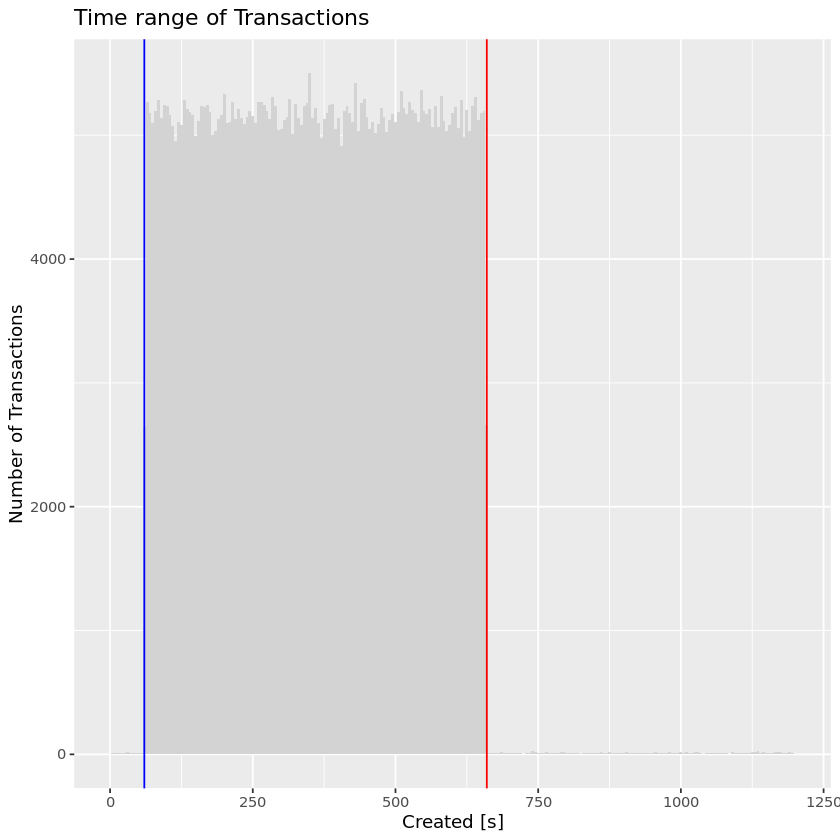

In [7]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [8]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/1024/2048/0.2
    ),
    .(`Time step [ms]`)
]

Time step [ms],Demand [tx/s],Demand [MB/s],Demand [IB/s]
<fct>,<dbl>,<dbl>,<dbl>
time step = 0.05 ms,1031.168,0.3093505,0.7375491


#### Size of persisted data

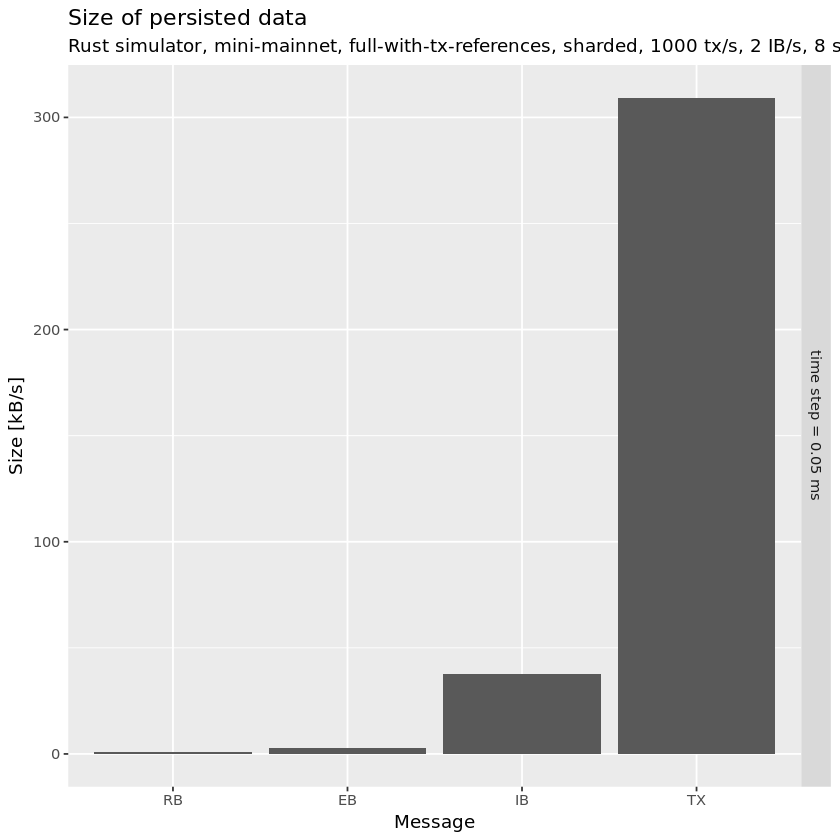

In [9]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Time step [ms]`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`Time step [ms]` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [10]:
ggsave("plots/tsr/sizes.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("plots/tsr/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

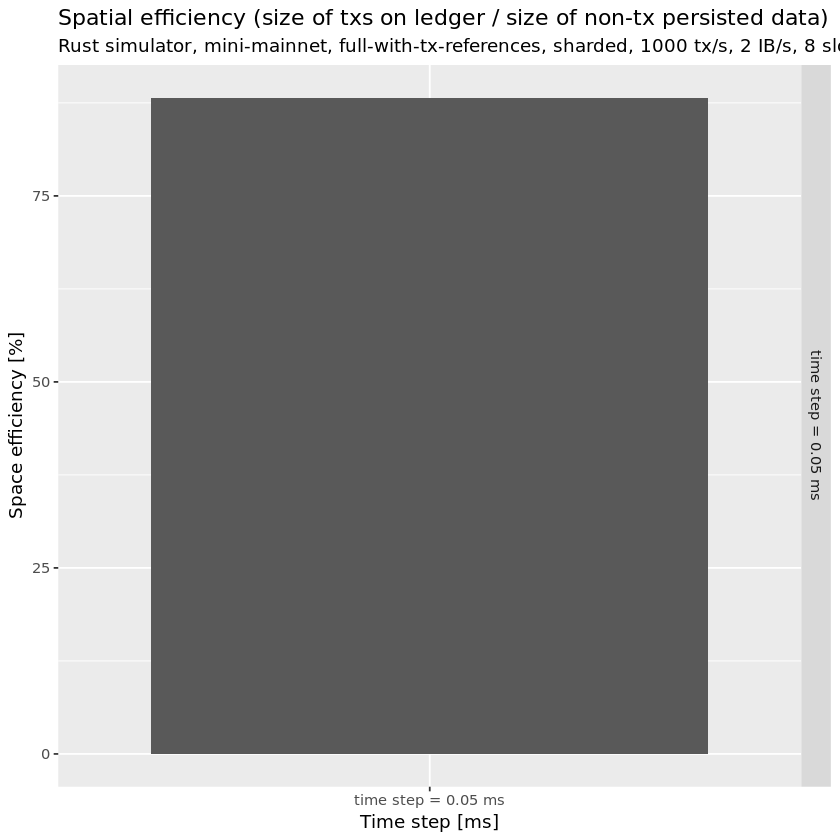

In [12]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Time step [ms]`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Time step [ms]`)
        ],
        on=c("Time step [ms]")
    ][, .(`Time step [ms]`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Time step [ms]`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Time step [ms]` ~ ., scales="free") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [13]:
ggsave("plots/tsr/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [14]:
ggsave("plots/tsr/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

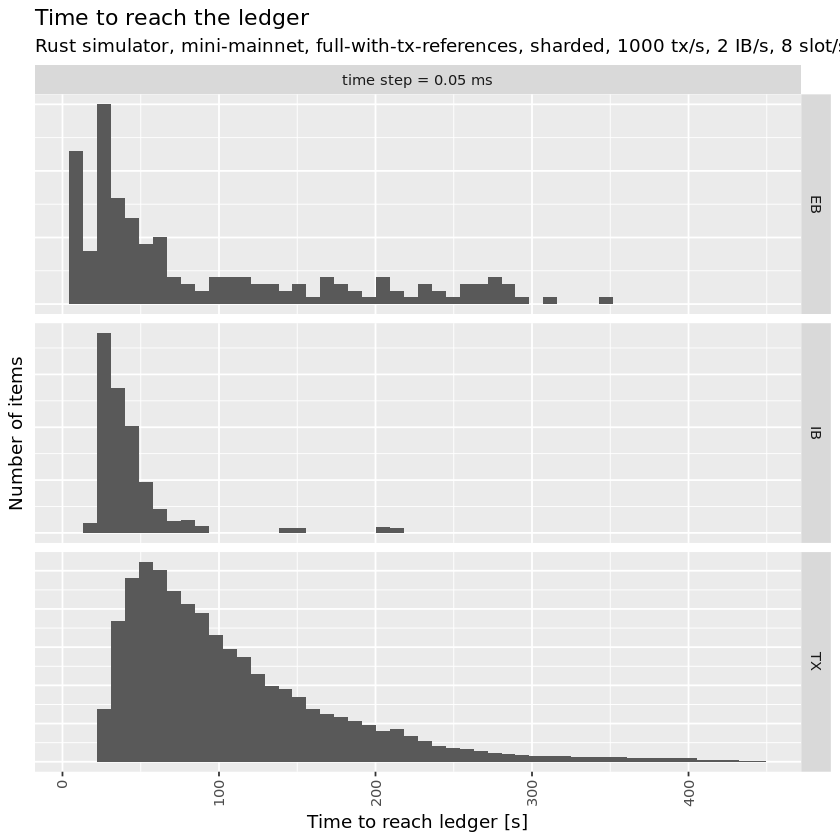

In [15]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Time step [ms]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_grid(`Kind` ~ `Time step [ms]`, scales="free") +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [16]:
ggsave("plots/tsr/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/tsr/reach-rb.svg", units="in", dpi=150, width=8, height=6)

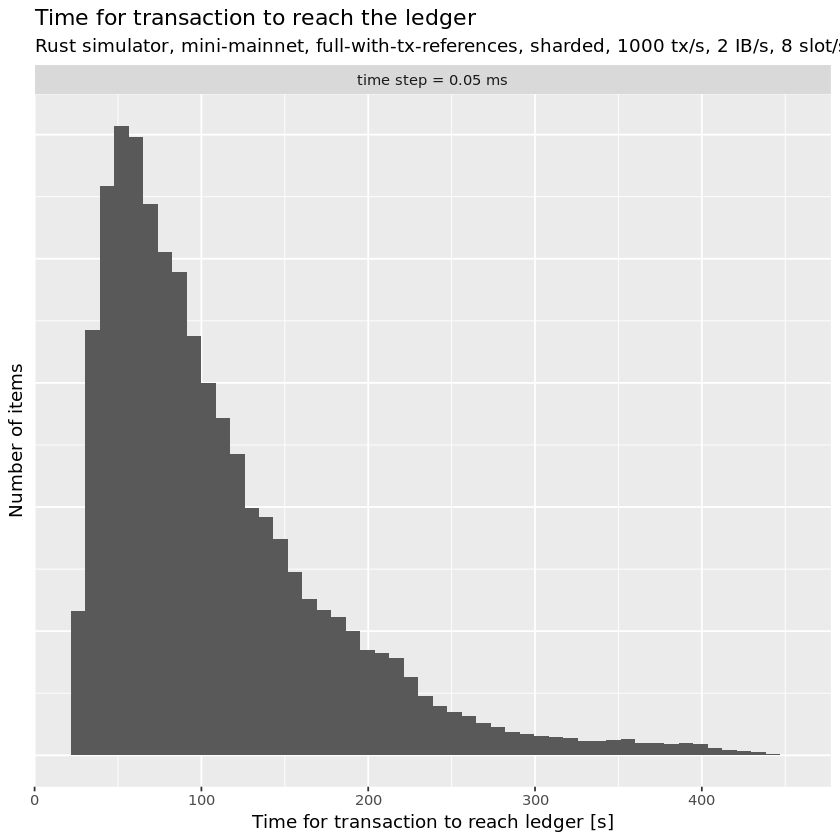

In [18]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Time step [ms]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_grid(. ~ `Time step [ms]`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [19]:
ggsave("plots/tsr/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("plots/tsr/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

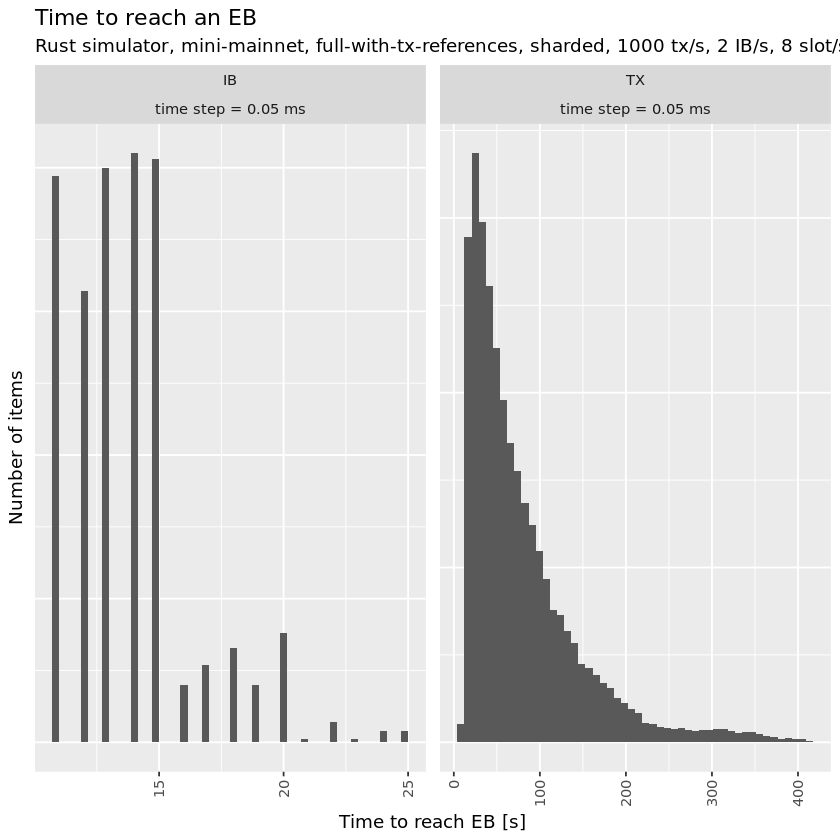

In [21]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `Time step [ms]`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Time step [ms]`, scales="free") +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [22]:
ggsave("plots/tsr/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [23]:
ggsave("plots/tsr/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

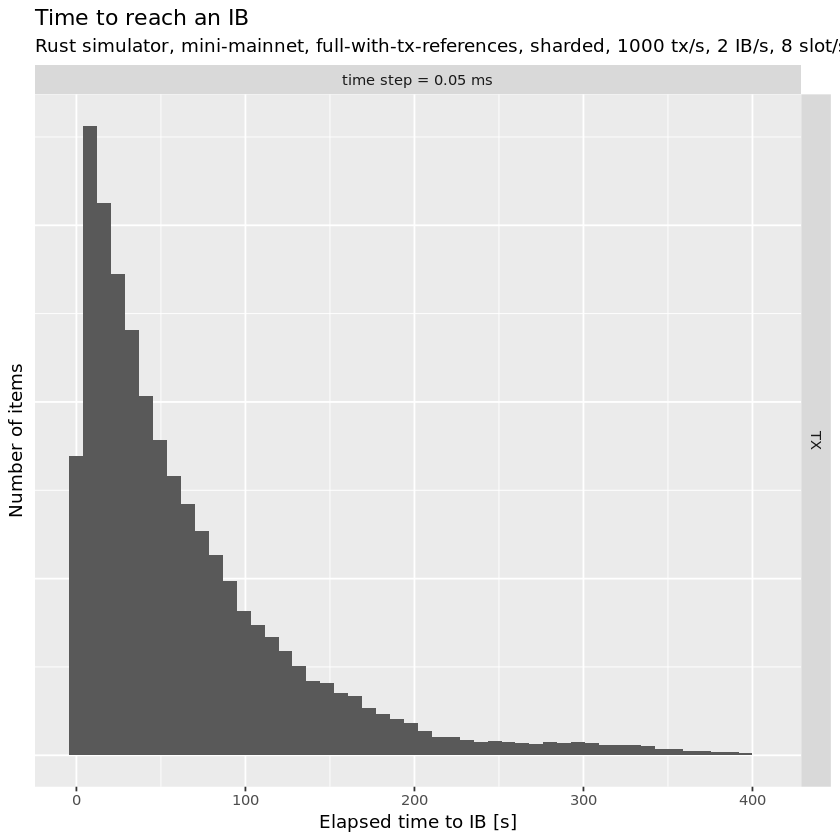

In [24]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `Time step [ms]`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_grid(`Kind` ~ `Time step [ms]`, scales="free") +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [25]:
ggsave("plots/tsr/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [26]:
ggsave("plots/tsr/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

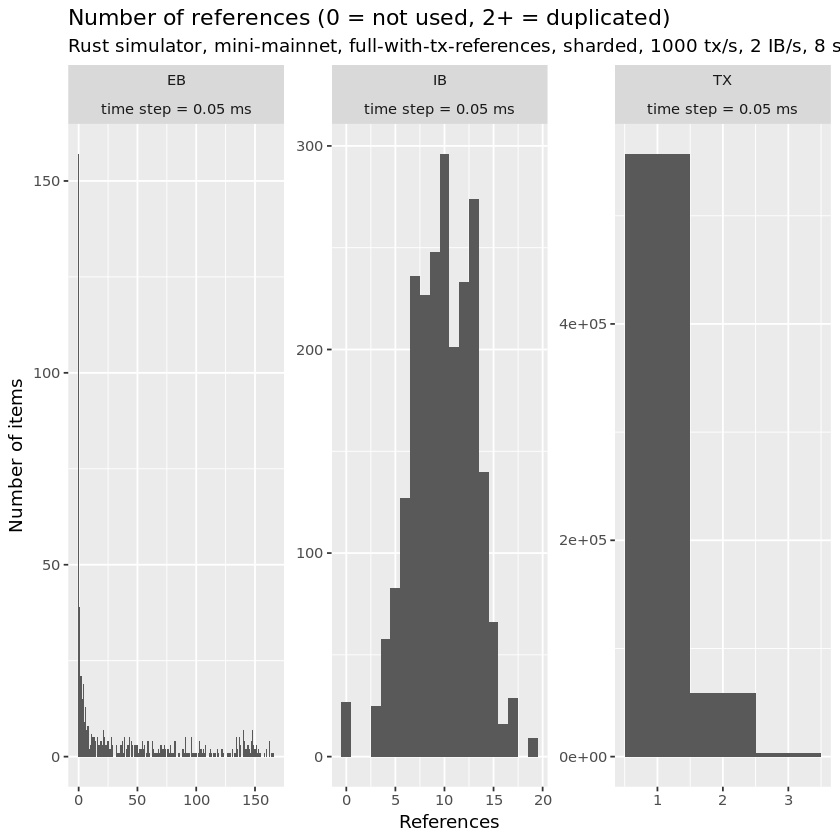

In [27]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `Time step [ms]`, scales="free") +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [28]:
ggsave("plots/tsr/references.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("plots/tsr/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [30]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [31]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Time step [ms]`
    )
][order(`Time step [ms]`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [32]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Time step [ms]`, `Submitted [minute]`)]

#### Transactions reaching the ledger

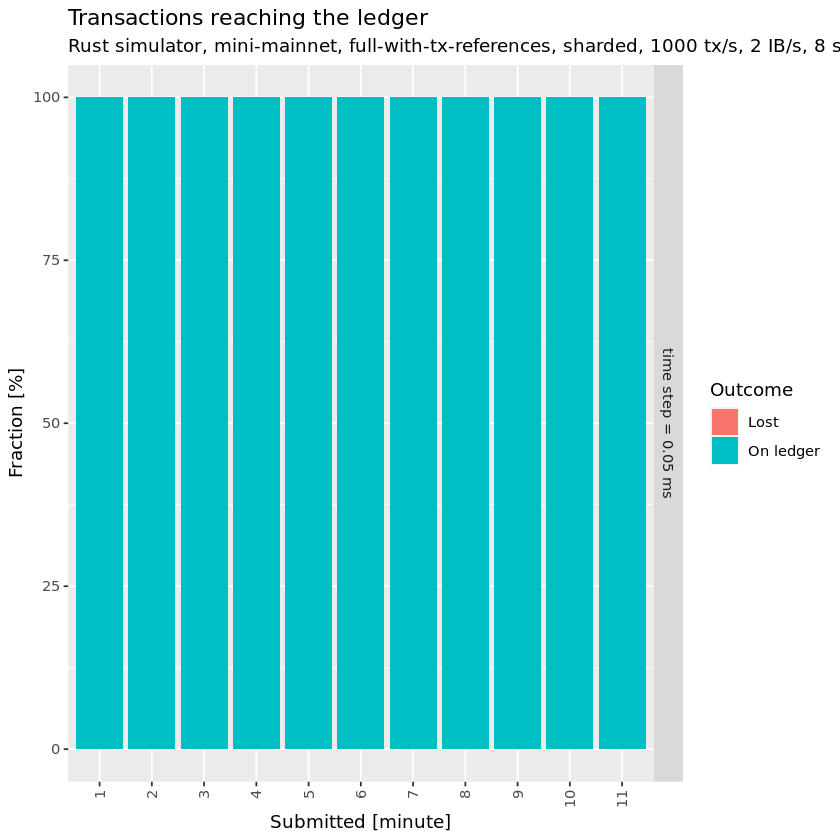

In [33]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Time step [ms]`, `Submitted [minute]`)],
        id.vars=c("Time step [ms]", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Time step [ms]`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Time step [ms]` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [34]:
ggsave("plots/tsr/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [35]:
ggsave("plots/tsr/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

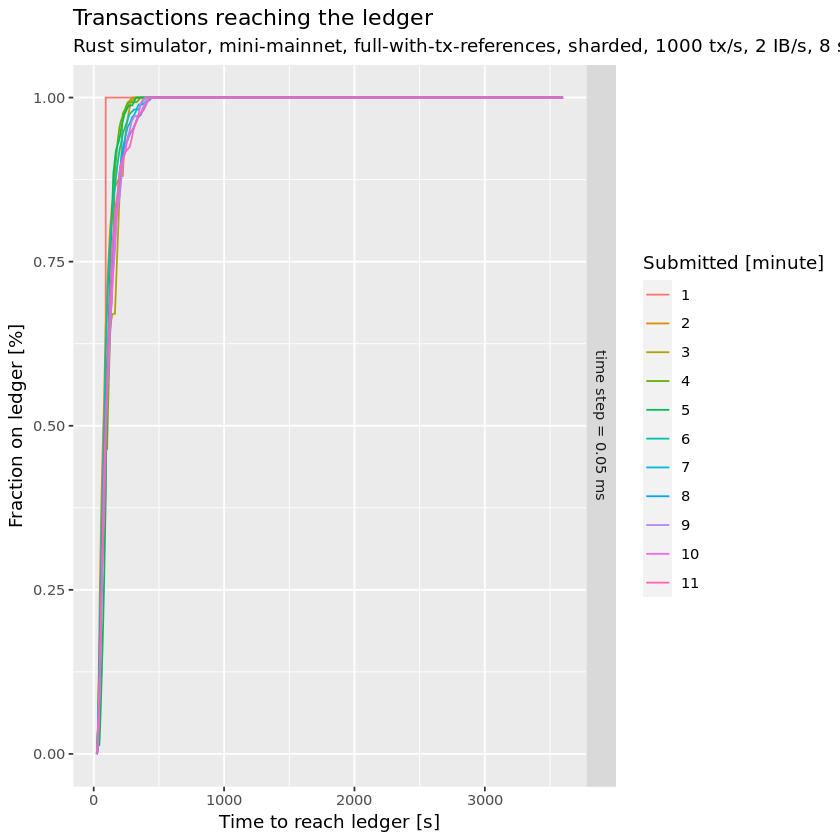

In [36]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Time step [ms]`, `Submitted [minute]`)],
            on=c("Time step [ms]", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Time step [ms]`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Time step [ms]`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Time step [ms]` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [37]:
ggsave("plots/tsr/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [38]:
ggsave("plots/tsr/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [39]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [40]:
resources <- fread("results/tsr/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 Simulator  Time step [ms]       Node       Egress [B]           Disk [B]     
 Rust:750   Min.   :0.05   node-0  :  1   Min.   :1.686e+05   Min.   :     0  
            1st Qu.:0.05   node-1  :  1   1st Qu.:1.491e+07   1st Qu.:     0  
            Median :0.05   node-10 :  1   Median :1.508e+08   Median :     0  
            Mean   :0.05   node-100:  1   Mean   :2.203e+08   Mean   : 33062  
            3rd Qu.:0.05   node-101:  1   3rd Qu.:3.026e+08   3rd Qu.: 61880  
            Max.   :0.05   node-102:  1   Max.   :1.453e+09   Max.   :241568  
                           (Other) :744                                       
 Total CPU [s]   Maximum CPU [s/s]
 Min.   :365.0   Min.   :1.230    
 1st Qu.:365.7   1st Qu.:1.545    
 Median :365.7   Median :1.552    
 Mean   :365.7   Mean   :1.536    
 3rd Qu.:365.7   3rd Qu.:1.557    
 Max.   :366.6   Max.   :1.896    
                                  

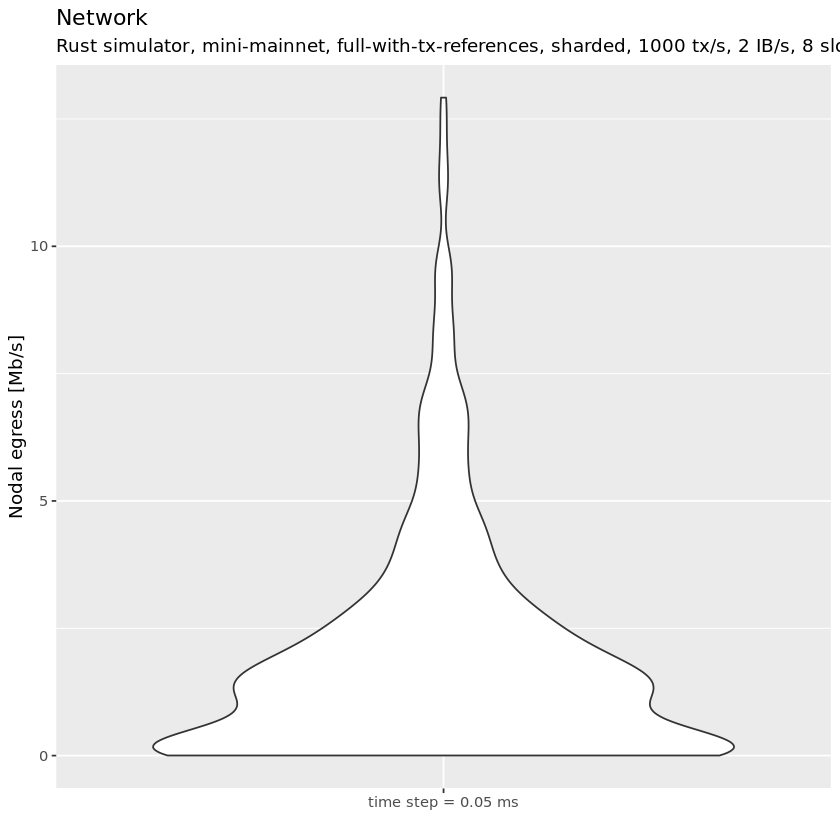

In [41]:
ggplot(
    resources[, .(`Time step [ms]`=txFactor(`Time step [ms]`), `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Time step [ms]`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    xlab("") +
    ggtitle("Network", label)

In [42]:
ggsave("plots/tsr/network.png", units="in", dpi=150, width=9.5, height=5.5)

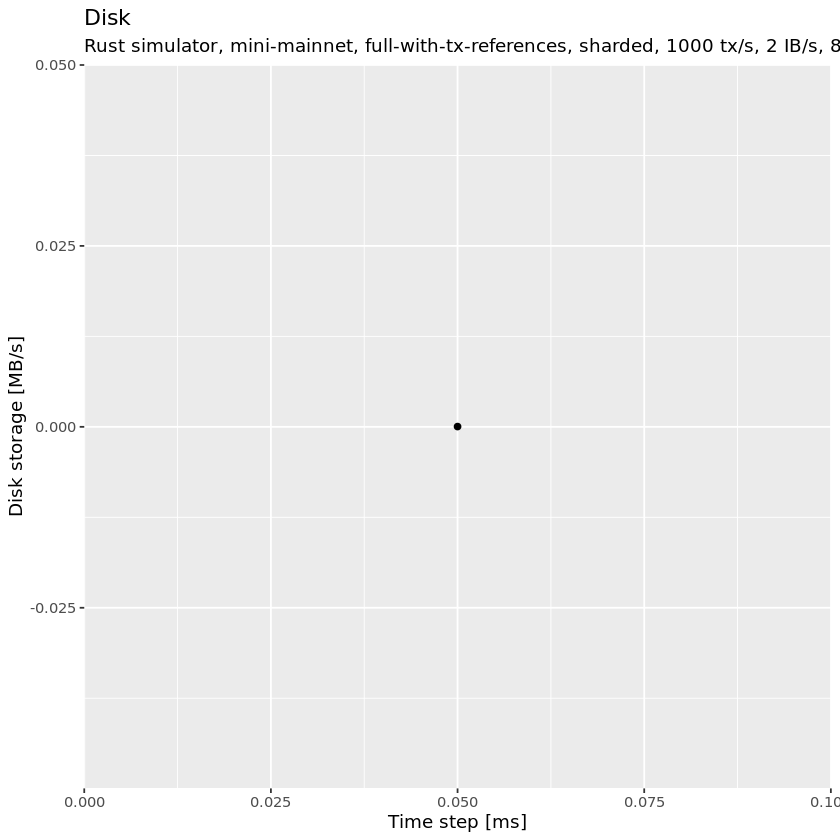

In [43]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Time step [ms]`)],
    aes(x=`Time step [ms]`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [44]:
ggsave("plots/tsr/disk.png", units="in", dpi=150, width=9.5, height=5.5)

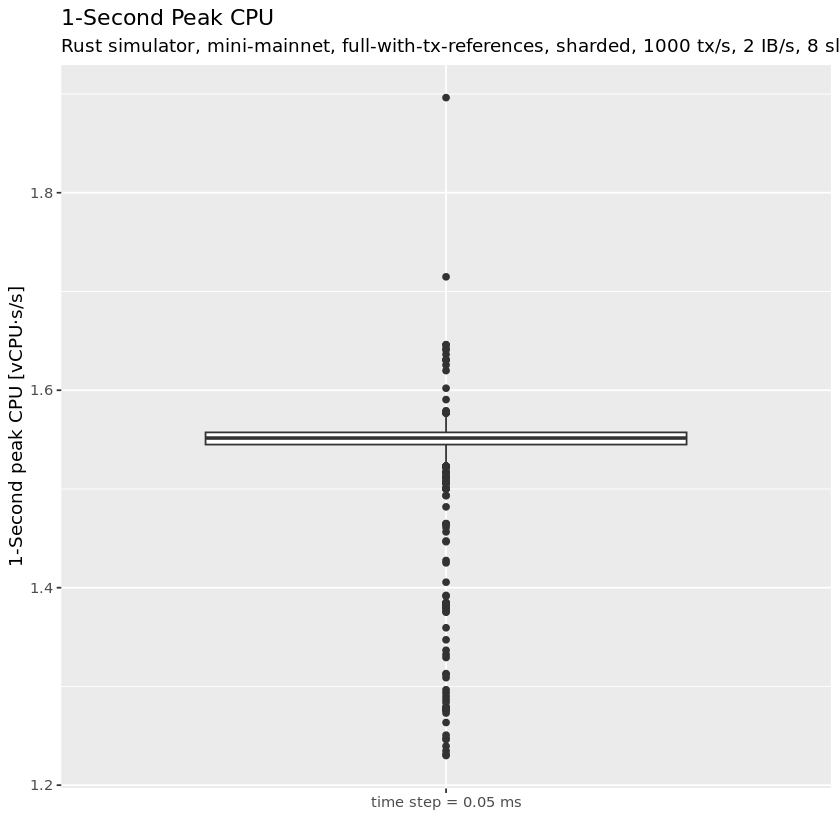

In [45]:
ggplot(
    resources[, .(`Node`, `Time step [ms]`=txFactor(`Time step [ms]`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Time step [ms]`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [46]:
ggsave("plots/tsr/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

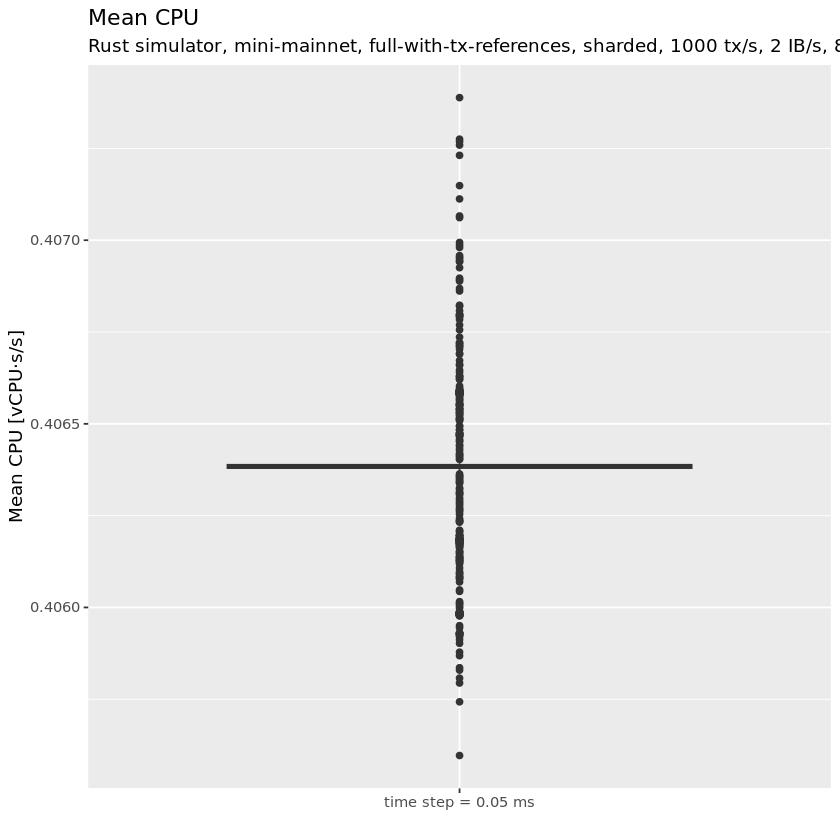

In [47]:
ggplot(
    resources[, .(`Time step [ms]`=txFactor(`Time step [ms]`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Time step [ms]`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [48]:
ggsave("plots/tsr/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [49]:
rm(resources)

### Receipt of messages

#### Read results

In [50]:
receipts <- fread("results/tsr/receipts.csv.gz", stringsAsFactors=TRUE)
receipts[, `Time step [ms]`:=txFactor(`Time step [ms]`, TRUE)]
receipts %>% summary

 Simulator                    Time step [ms]      Kind          
 Rust:495978454   time step = 0.05 ms:495978454   EB:   444157  
                                                  IB:  1718939  
                                                  RB:    55084  
                                                  TX:463407049  
                                                  VT: 30353225  
                                                                
                                                                
            Item               Producer         Generated [s]    
 1000-node-427:     1498   node-331:  1755656   Min.   :   1.13  
 1000-node-525:     1498   node-72 :   949732   1st Qu.: 214.11  
 1000-node-557:     1498   node-706:   948234   Median : 369.00  
 1000-node-561:     1498   node-129:   936250   Mean   : 377.33  
 1005-node-147:     1498   node-690:   932505   3rd Qu.: 524.83  
 1005-node-181:     1498   node-235:   926513   Max.   :1198.13  
 (Other)      :495

In [51]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [52]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `Time step [ms]`, `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

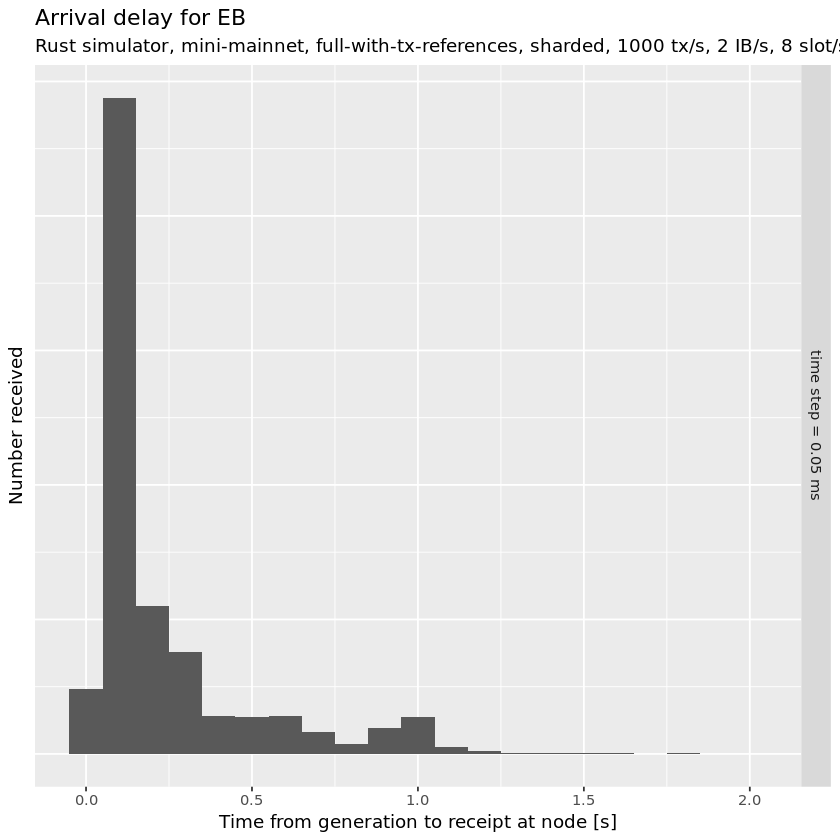

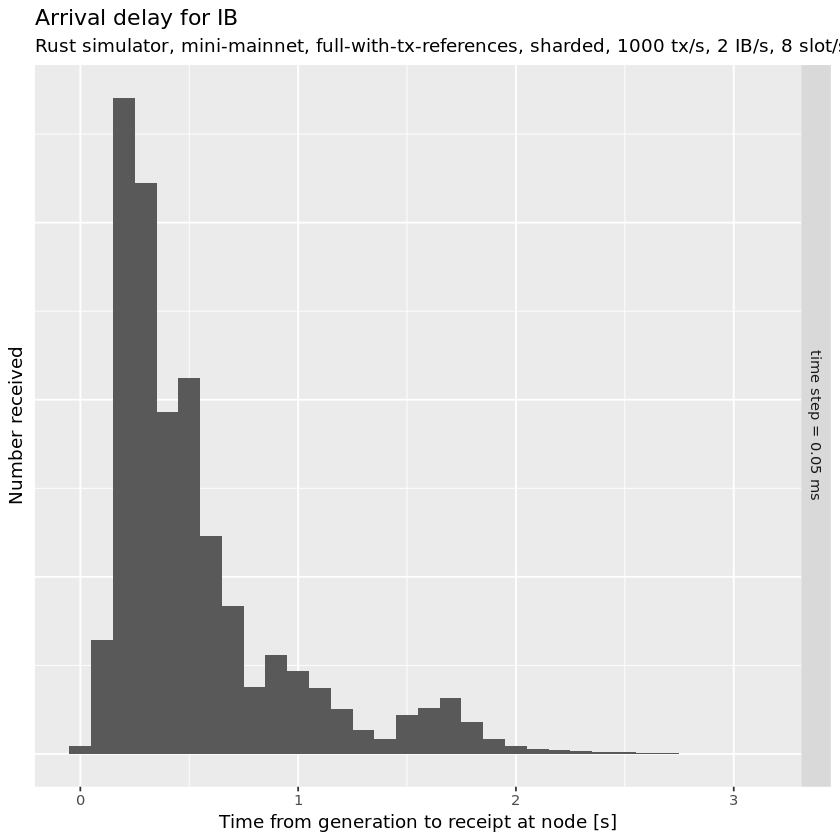

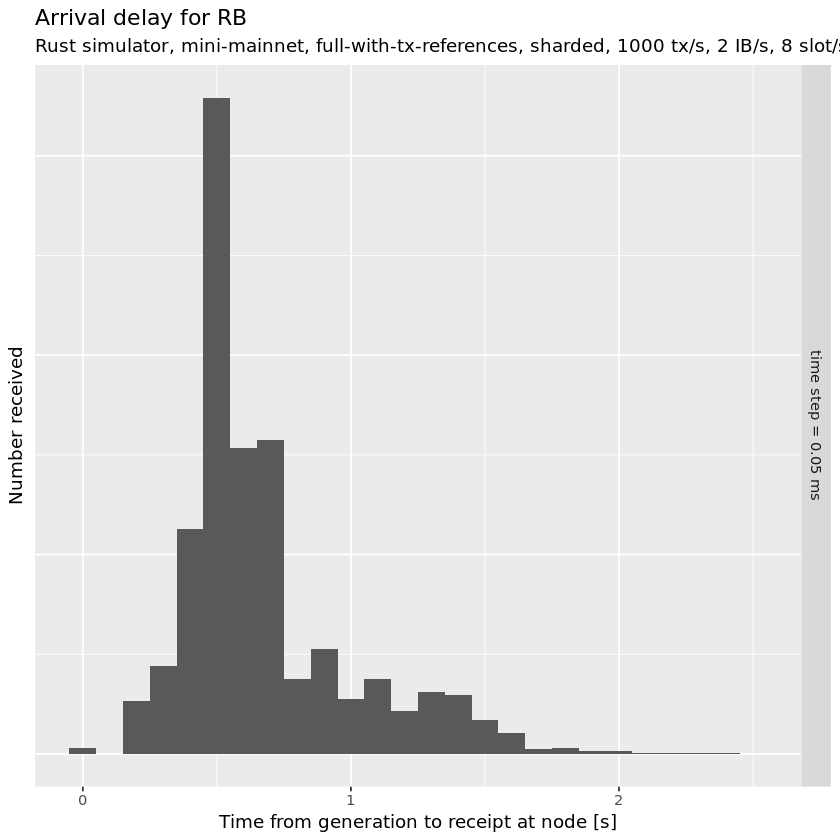

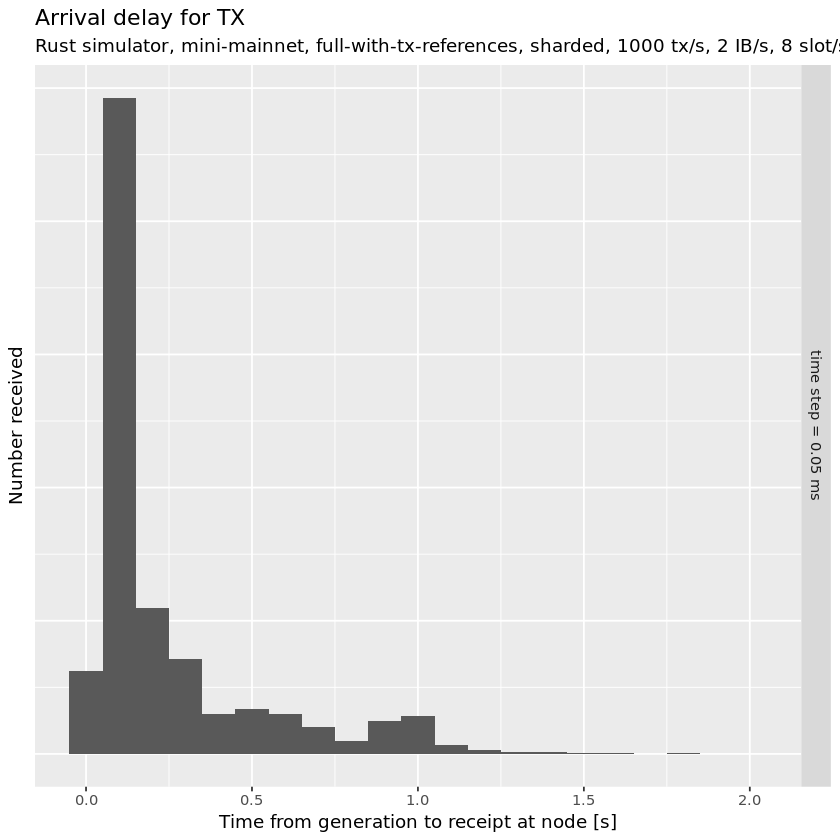

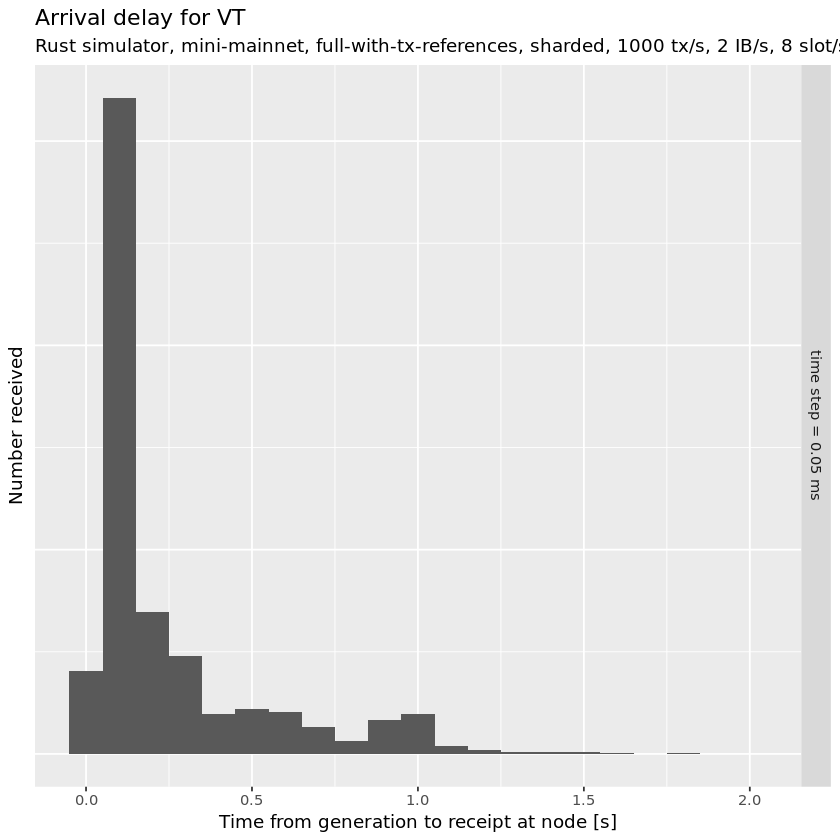

In [53]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/tsr/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [54]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `Time step [ms]`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `Time step [ms]`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `Time step [ms]`, `Generated [s]`)
        ][, .(`Simulator`, `Time step [ms]`, `Generated [s]`,`Received`)
        ], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Time step [ms]`  ~ ., scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

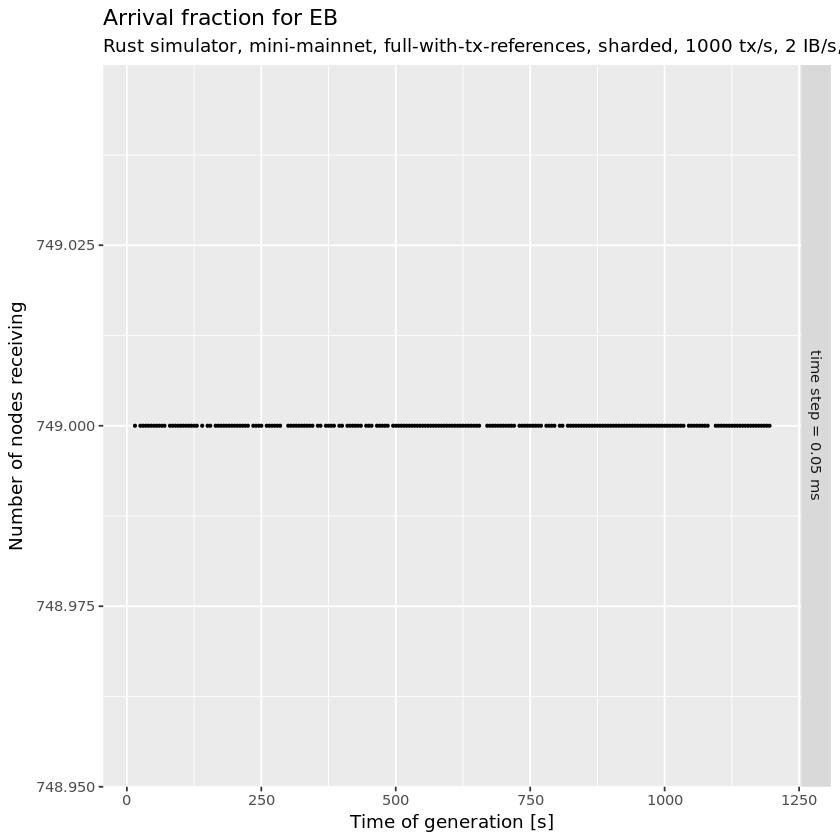

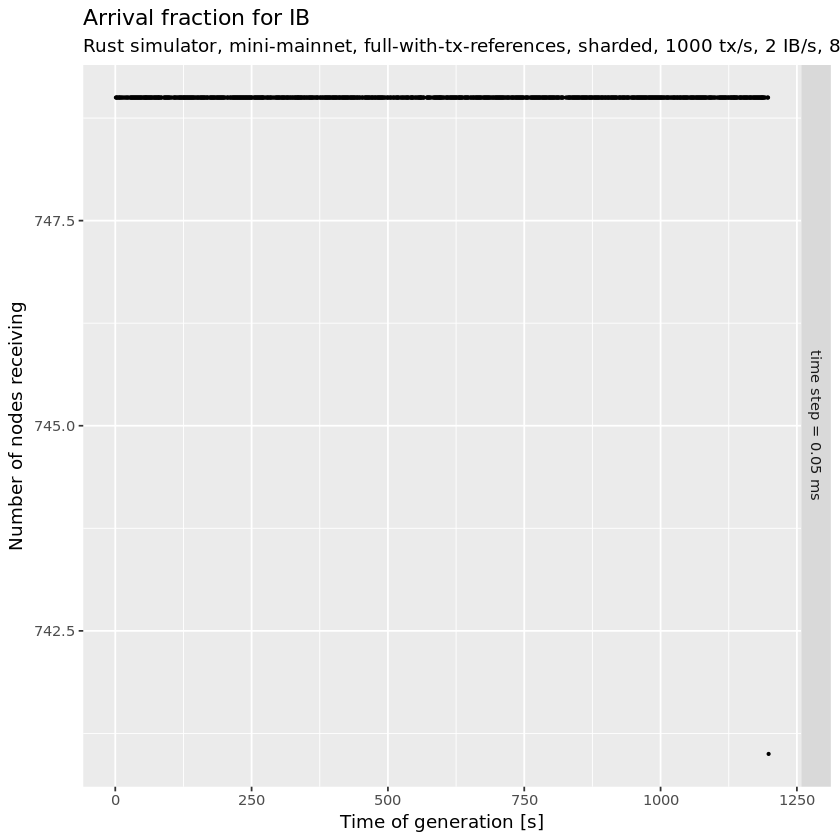

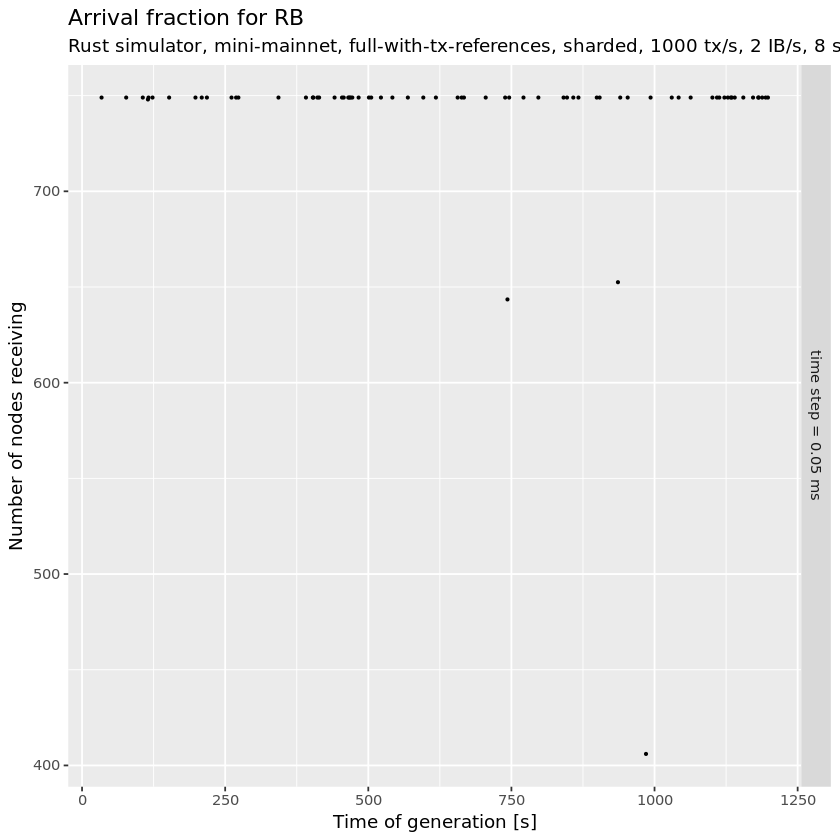

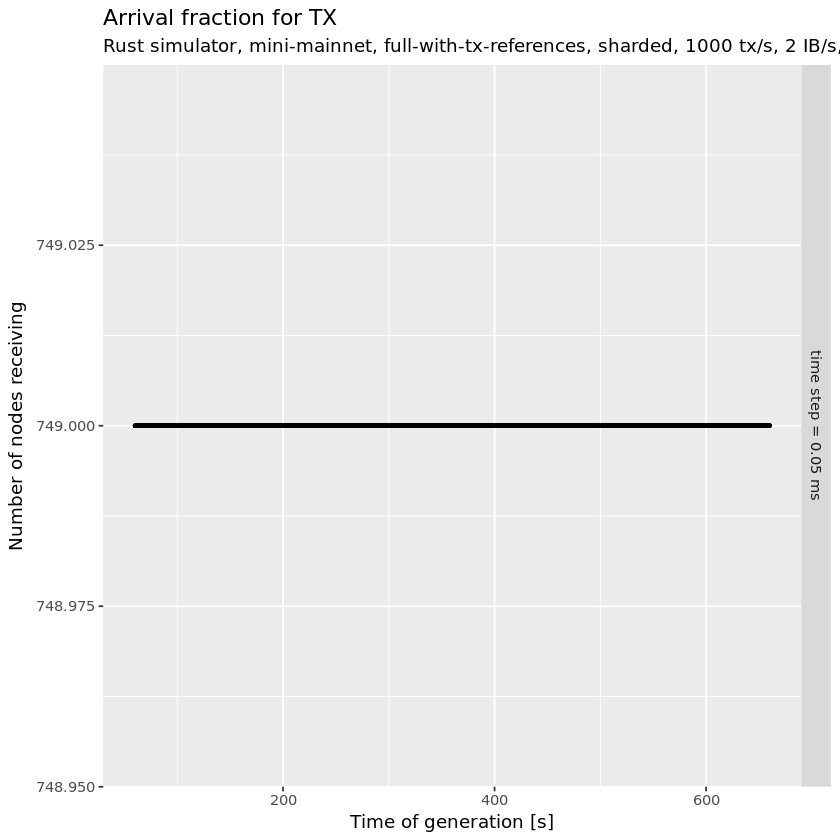

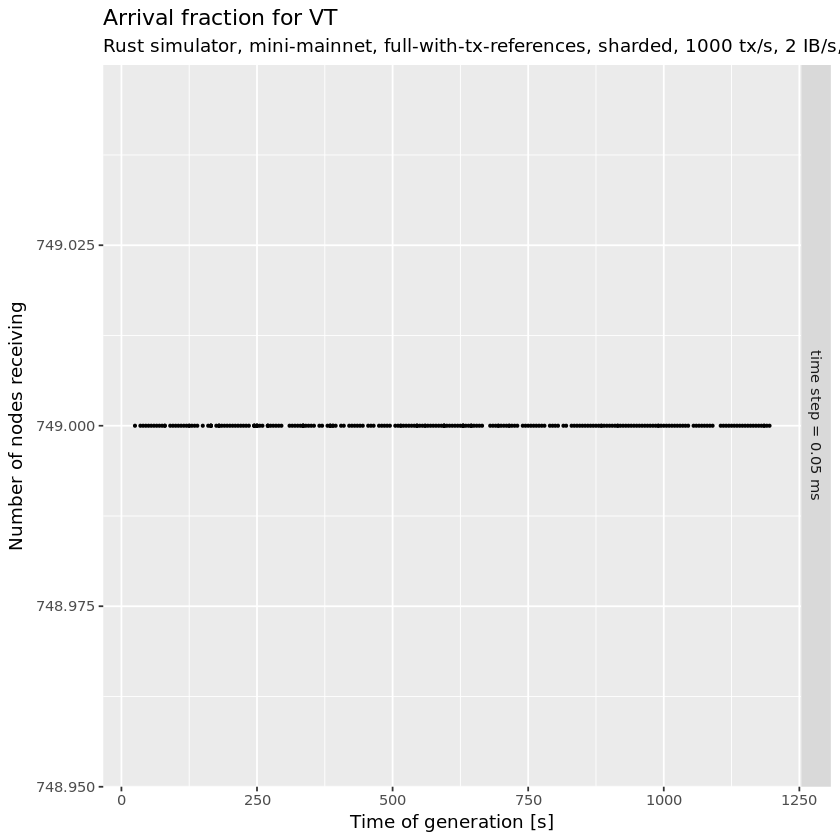

In [55]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/tsr/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [56]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `Time step [ms]`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

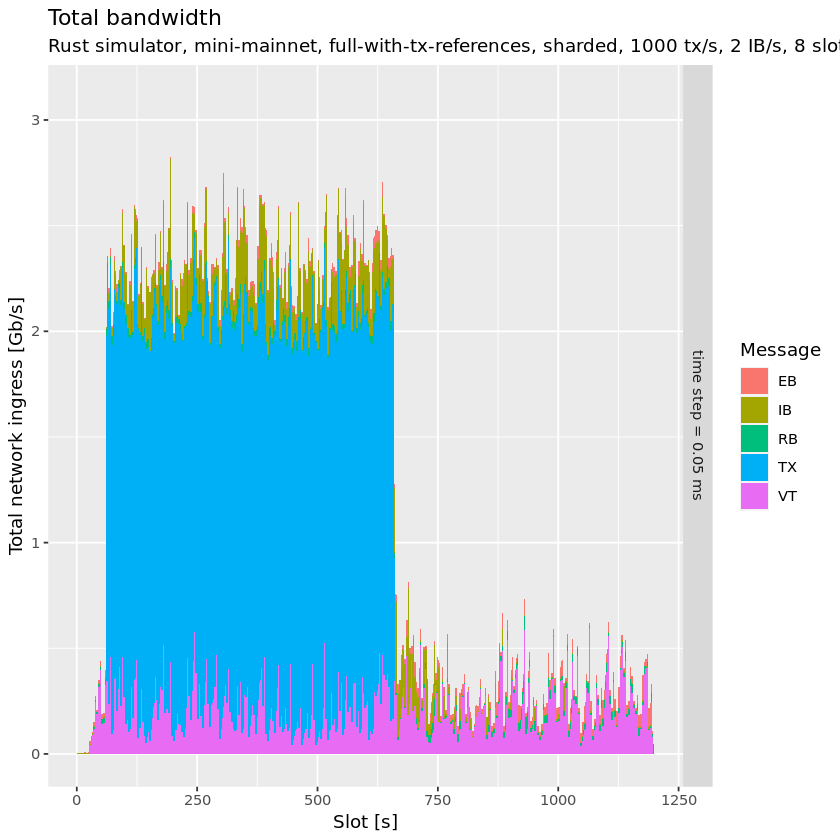

In [57]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/tsr/ingress-total-area.png")
)

##### Bandwidth usage per node

In [58]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [59]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Simulator`,
                `Time step [ms]`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

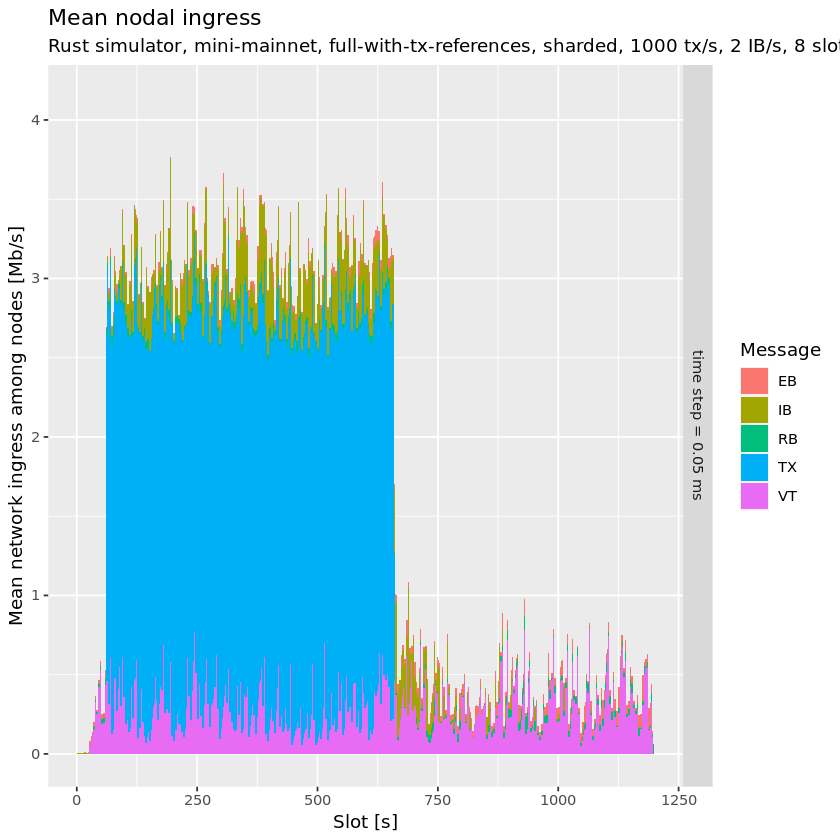

In [60]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/tsr/ingress-average-area.png")
)

In [61]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `Time step [ms]`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Simulator`, `Time step [ms]`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

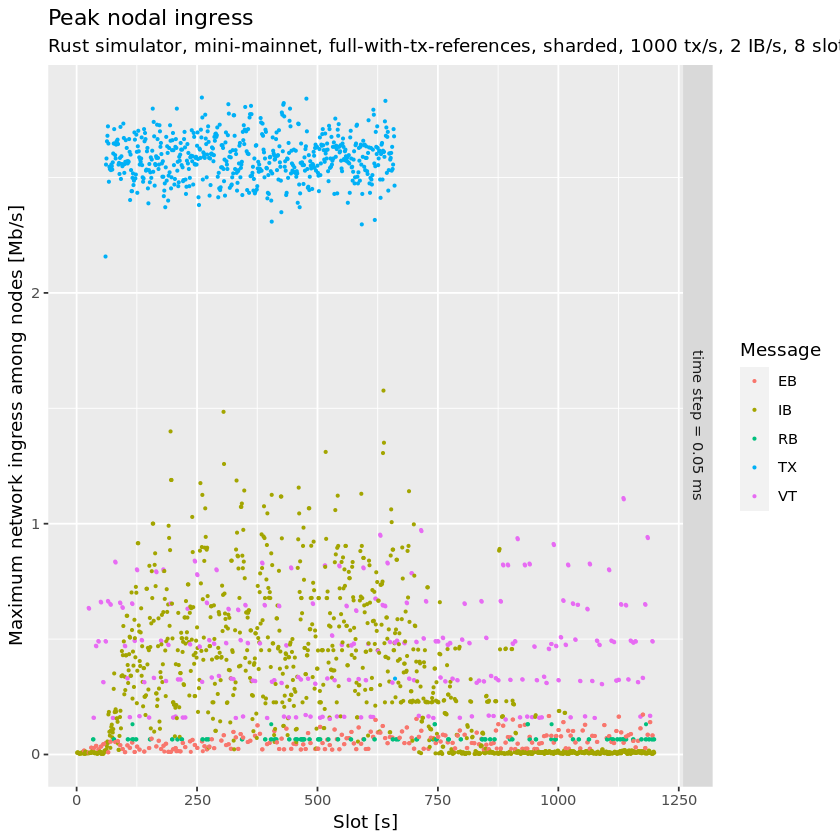

In [62]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/tsr/ingress-peak-point.png")
)

#### Release memory

In [63]:
rm(receipts)

### CPU usage

#### Read results

In [65]:
cpus <- fread("results/tsr/cpus.csv.gz", stringsAsFactors=TRUE)
cpus[, `Time step [ms]`:=txFactor(`Time step [ms]`, TRUE)]
cpus %>% summary

 Simulator                    Time step [ms]           Slot       
 Rust:551980147   time step = 0.05 ms:551980147   Min.   :   1.0  
                                                  1st Qu.: 219.0  
                                                  Median : 383.0  
                                                  Mean   : 402.6  
                                                  3rd Qu.: 548.0  
                                                  Max.   :1199.0  
                                                                  
       Node                Task            Duration [s]     
 node-253:   736802   ValTX  :463407049   Min.   :0.000065  
 node-204:   736798   ValVote: 84520156   1st Qu.:0.000065  
 node-168:   736797   ValIH  :  1718955   Median :0.000065  
 node-437:   736797   ValIB  :  1718939   Mean   :0.000497  
 node-494:   736797   ValEB  :   444157   3rd Qu.:0.000065  
 node-592:   736797   GenVote:   112844   Max.   :0.181000  
 (Other) :547559359   (Other):    580

In [66]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Simulator`, `Time step [ms]`, `Node`, `Slot`)
]

#### Peak CPU usage

##### Histogram

In [67]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Simulator`, `Time step [ms]`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

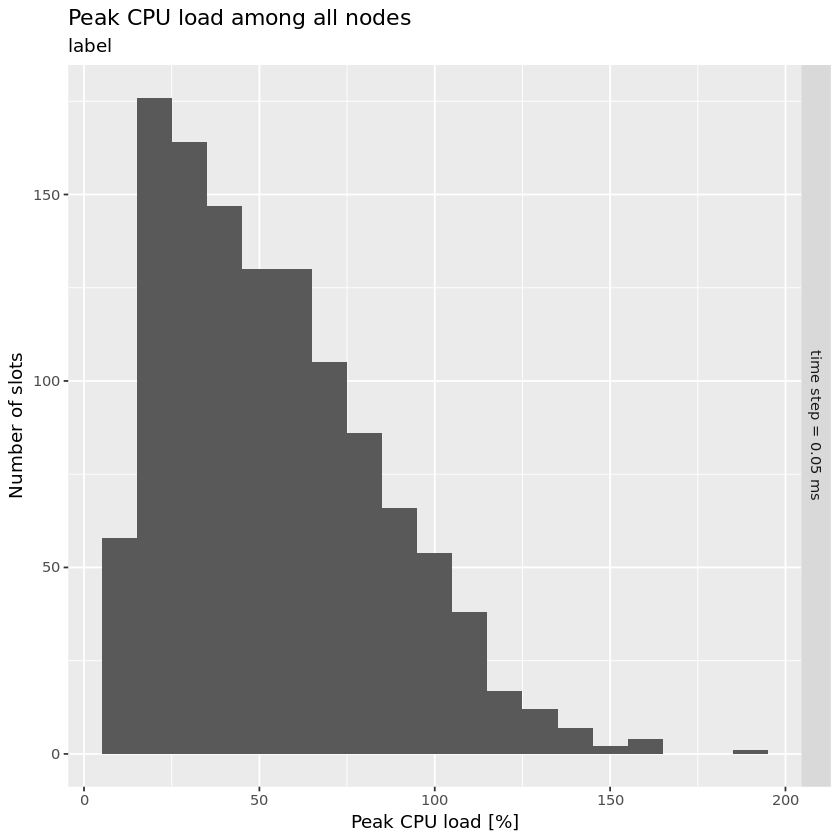

In [68]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/tsr/cpu-peak-histogram.png")
)

##### Time series

In [69]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)),
            by=.(`Simulator`, `Time step [ms]`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Time step [ms]` ~ ., scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

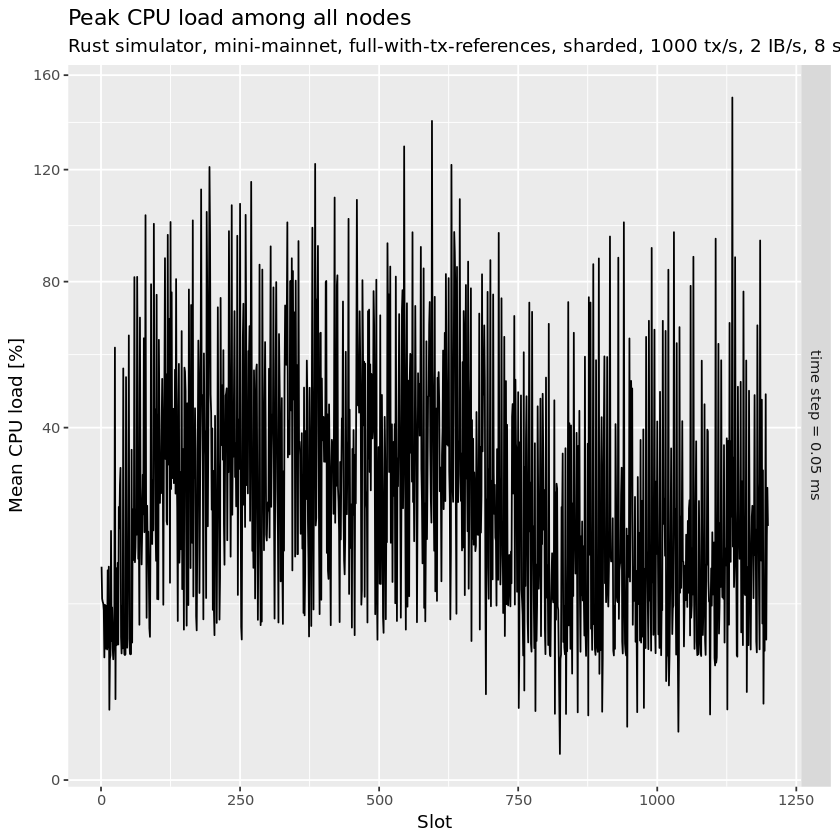

In [70]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/tsr/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [71]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Simulator`, `Time step [ms]`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

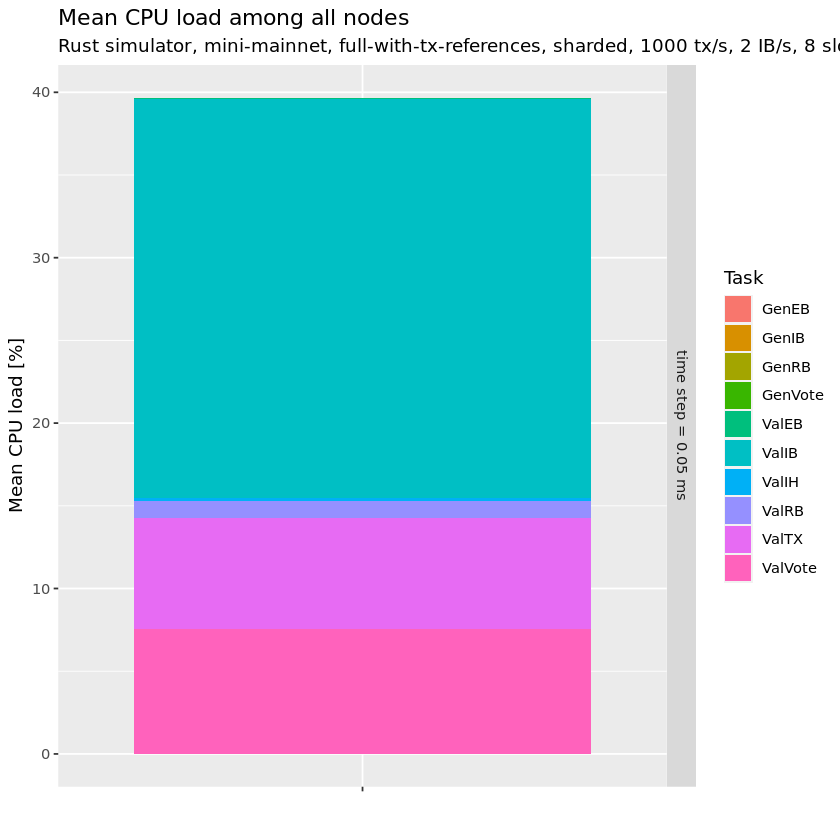

In [72]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/tsr/cpu-mean-histogram.png")
)

##### Time series

In [73]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Simulator`, `Time step [ms]`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Time step [ms]` ~ ., scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

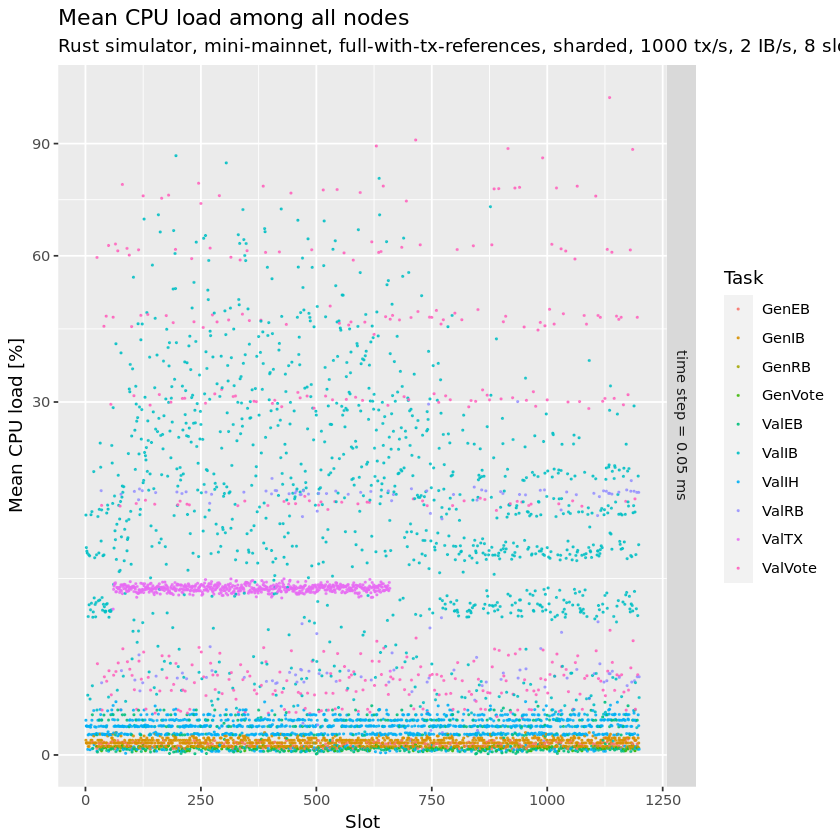

In [74]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/tsr/cpu-mean-timeseries.png")
)

#### Release memory

In [75]:
rm(cpus, cpusNode)